In [1]:
import matplotlib
from matplotlib.pyplot import *
import math
import random

import ipywidgets as W
from IPython.display import display
import time


In [36]:
def old_invert_dict(D):
    if not D:
        return D
    if len(set(D.values())) == len(D):
        return dict( (I, k) for (k, I) in D.items() )
    E = {}
    for I in D.values():
        E[I] = []
    for k in D:
        E[D[k]].append(k)
    return E

In [37]:
def invert_dict(D):
    """Simplified function that should work well enough."""
    return {v: k for k, v in D.items()}

In [40]:
def test_invert_dict(D, result):
    r = invert_dict(D)
    print(r, result)
    assert r == result

# Data updated for simpler/faster design
rd_list = (
    ({}, {}),
    ({1: 2}, {2: 1}),
    ({1: 2, 3: 2}, {2: 3})
)

for d, r in rd_list:
    test_invert_dict(d, r)

{} {}
{2: 1} {2: 1}
{2: 3} {2: 3}


In [41]:
d = {i: i*i for i in range(40)}
%timeit old_invert_dict(d)
%timeit invert_dict(d)

9.97 µs ± 718 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.92 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        
    def __str__(self):
        return "({0},{1})".format(self.x,self.y)    
    
    def line_to(self, q):
        return Line(self.y - q.y, -self.x + q.x, self.x* q.y - self.y * q.x)   
       
    def plus(self, q):
        return Point(self.x + q.x, self.y + q.y)
    
    def minus(self, q):
        return Point(self.x - q.x, self.y - q.y)

    def scalarmu(self, mu):
        x = mu * self.x
        y = mu * self.y
        return Point(x,y)
    
    def scalarprod(self, q):
        return self.x * q.x + self.y * q.y
    
    def reflect(self, p, q):
        t = self.minus(q).scalarprod(p.minus(q)) / p.minus(q).scalarprod(p.minus(q))
        M = q.scalarmu(1-t).plus(p.scalarmu(t))
        return M.scalarmu(2).minus(self)

    def half_reflect(self, p, q):
        t = self.minus(q).scalarprod(p.minus(q)) / p.minus(q).scalarprod(p.minus(q))
        M = q.scalarmu(1-t).plus(p.scalarmu(t))
        return M
    
    
    def is_inside(self, P):
        # the problem of intersection requires attention. 
        vals = [P[n].line_to(P[(n + 1) % len(P)]).at(self) for n in range(len(P))]
        return max(vals) <= 0 or min(vals) >= 0
    
    def perpbis(self, q): # get equation of perpendicular bisector of self and q
        dx = self.x - q.x
        dy = self.y - q.y
        a = (dx * dx + dy * dy) / 2 + q.x * dx + q.y * dy
        return Line(dx, dy, -a)
    
    def Pshrink_to(self, Plist, scale = 1):
        # scaling transform on Plist using self as origin
        def Pshrinkto(P, Q, sc):
            Px = Q.x - (Q.x - P.x ) * sc
            Py = Q.y - (Q.y - P.y ) * sc
            return Point(Px, Py)
        outlist = []
        Q = self
        for P in Plist:
            outlist.append(Pshrink(P, Q, scale))
        return outlist
    
    def distance_from(self, q):
        dx = self.x - q.x
        dy = self.y - q.y
        return math.sqrt(dx * dx + dy * dy)
                
            


Pinf = Point(10000,10000)

In [5]:
class Line():
    def __init__(self, a, b, c):
        # normalize
        root = math.sqrt(a * a + b * b)
        self.a = a / root
        self.b = b / root
        self.c = c / root
        
    def same_side(self, p, q):
        return self.at(p) * self.at(q) >= 0
    
    def polygon_clip(self, poly): # returns a list of intersection points of self with poly
        n = len(poly)
        clip = []
        for q in range(n):
            p = (q + 1) % n
            if not self.same_side(poly[p], poly[q]):
                r = self.intercept(poly[p], poly[q])
                if not r == Pinf:
                    clip.append(r)
        return clip
   
    def polygon_update(self, poly): # should only be called if we are sure that
                                    # there are two intersection points (call polygon_clip first)
        n = len(poly)
        poly2 = []
        poly2.append([])
        poly2.append([])
        current = 0
        for p in range(n):
            poly2[current].append(poly[p])
            q = (p + 1) % n
            if not self.same_side(poly[p], poly[q]):
                r = self.intercept(poly[p], poly[q])
                poly2[current].append(r)
                current = (current + 1) % 2
                poly2[current].append(r)
       
        return poly2 # NB poly2 returns a LIST containing two polygons
    
    # evaluate linear function at p
    def at(self, p):
        return self.a * p.x + self.b * p.y + self.c
    
    def sum_of_distance(self, poly): # NB these signed distances are only used in determining whether                                  
                                     # a point is inside or outside a polygon, so all 'distances' will
                                     # have the same sign, which is all we need.
                                     # using sum was a crude device to avoid having to select a test vertex
        sum = 0
        n = len(poly)
        for p in poly:
            sum += self.at(p)
        return sum
  
    def intercept(self, p, q):
        """ returns the point of intersection of self with the line joining p and q"""
        s = (self.a * (p.x - q.x) + self.b * (p.y - q.y)) # determinant
        if  math.isclose(s, 0):
            print('Pinf in intercept()')
            return Pinf # point at infinity. not really implemented as yet!
        else:
            t = (self.a * p.x + self.b * p.y + self.c)/s
            return p.scalarmu(1-t).plus(q.scalarmu(t))
    
    def intercept_t(self, p, q):
        """ returns the point of intersection of self with the line joining p and q"""
        s = (self.a * (p.x - q.x) + self.b * (p.y - q.y)) # determinant
        if  math.isclose(s, 0):
            print('infinity in intercept()')
            return INF # infinity. not really implemented as yet!
        else:
            t = (self.a * p.x + self.b * p.y + self.c)/s
            return t

    def meets(self, L):
        a1, b1, c1 = self.a, self.b, self.c
        a2, b2, c2 = L.a, L.b, L.c
        det = a1 * b2 - a2 * b1
        if math.isclose(det,0):
            print('Pinf in meets()')
            return Pinf
        xfac = c1 * b2 - c2 * b1
        yfac = a1 * c2 - a2 * c1
        return Point( -xfac / det, -yfac / det)
   
INF = 10000
        

In [6]:
def ranpoints(N = 24):
    """samples N Points from a uniform distribution on (-1, 1) x (-1, 1)"""
    plist = []
    for k in range (N):
        plist.append(Point(2 * (random.random() - 0.5), 2 * (random.random() - 0.5)))
    return plist



def barycenter(pointlist):
    """returns the centroid of a list of points"""
    n = len(pointlist)
    if n == 0:
        print('error in barycenter() - input list empty')
        return Pinf
    xlist = []
    ylist = []
    for P in pointlist:
        xlist.append(P.x)
        ylist.append(P.y)
    x = np.sum(xlist) / n
    y = np.sum(ylist) / n
    return(Point(x, y))

def polar_scatter(n_points, concentration = 2):
    """ creates a random list of points focussed on the origin"""
    plist = []
   
    for n in range(n_points):
        
        theta = 2 * math.pi * random.random()
        r     = math.exp(- concentration * random.random())
        plist.append(Point(r * math.cos(theta), r * math.sin(theta)))
    
    return plist


In [7]:
def figurehead(f):
    #standard bit of graphics  plot initialization.  call this function to save typing
    figure(figsize=(f,f))
    axes().set_aspect('equal','datalim')


def polyplot(poly,*args,**kwargs):
    # now superseded by the poly kwarg in peedraw
    poly.append(poly[0])
    peedraw(plot, poly, *args, **kwargs)
    poly.pop()


def peedraw(func, pointlist, *args, poly = False, **kwargs): 
    """plots/fills/scatters a list of Points 
     (whereas the pyplot plot function takes a list of x and a list of y co-ords)
    func is the function name
    pointlist is the  list of Points 
    poly (default False) should be set to true when the closing arc is needed (plot only)
    NB differences in var lists, particularly scatter *args
   """
    x = []
    y = []
    for p in pointlist:
        x.append(p.x)
        y.append(p.y)
    if not poly:        
        func(x,y,*args,**kwargs)
    else:
        x.append(x[0])
        y.append(y[0])
        func(x, y, *args, **kwargs)

def circle(a, b, r, npoints = 500):
    """returns a listof points forming a regular polygon with npoints sides, center (a,b), radius r"""
    C = []
    
    for n in range(npoints):
        theta =  math.pi / 2 + 2 * math.pi * n / npoints
        C.append(Point(a + r * math.cos(theta), b + r * math.sin(theta)))
                     
    return C




In [8]:
  
def area(P):
    """returns the (unsigned) area of the polygon P (list of Points)"""
    s = 0
    for j in range(len(P)):
        k = (j +1) % len(P)
        s += (P[k].y + P[j].y) * (P[k].x - P[j].x)
    return abs ( s  / 2)

def perimeter(P):
    """returns the (unsigned) perimeter of the polygon P (list of Points)"""
    sum = 0
    for j in range(len(P)):
        k = (j +1) % len(P)
        dx = P[k].x - P[j].x
        dy = P[k].y - P[j].y
        sum += math.sqrt(dx * dx + dy * dy)
    return sum

In [9]:
def next_point(P, q, Q):
    """the engine of the 'network1 algorithm"""
    L = q.perpbis(Q) # get equation of perpendicular bisector of q and Q
    clip = L.polygon_clip(P) # list of intersection points of line L and polygon P
    if len(clip) == 2: # rule out any exceptional cases. this requires looking at later +++++++ NB +++++++++++
        poly2 = L.polygon_update(P)
        #polygon_update returns two lists, with the newly computed intersection points added to each.
        
        # to determine which of the twob polgygons q is in we use signed distances from L
        a0 = L.sum_of_distance(poly2[0])
        a1 = L.sum_of_distance(poly2[1])
        a = L.at(q) # value of ax + by +c for  q = (x, y)
        
        if a * a0 > 0 and poly2[0]: # a and a0 have same sign
            return poly2[0]
        else:
            return poly2[1]
    else:
        return P


def network1(poly, seedlist):
    """ returns a dictionary indexed by the seed points of polygons (as lists of points) 
    subdividing poly ( for poly = external boundary, only rectangles have been considered so far) 
    each output polygon defines the base region round one of the points of seedlist"""
    
    Q = list(seedlist)
    cell_dict = {} # polygon coordinates
    for q in Q:
        # reset the initial polygon
        P = list(poly)
        for nextq in Q:
            if not nextq == q:
                P = next_point(P, q, nextq)
        cell_dict[q] = P
    return cell_dict

#-------------------------------------------------------------------------------------
#

In [10]:
def next_vertex(P, j):
    return P[(j+1) % len(P)]

def poly_overlap(P, Q):
    def check_intersection(A, B, C, D):
        L1 = A.line_to(B)
        L2 = C.line_to(D)
        return L1.at(C) * L1.at(D) <= 0 and L2.at(A) * L2.at(B) <= 0
    score = False
    j = 0
    while not score and j < len(P):
        p = P[j]
        q = next_vertex(P, j)
        j += 1
        k = 0
        while not score and k < len(Q):
            r = Q[k]
            s = next_vertex(Q, k)
            k += 1
            score = check_intersection(p, q, r, s)
    return score



In [21]:
N_iterations = 5 # this will be user-selected in due course
scatter_dot_size = 7

def draw_diagram(screen,  seedlist, barycenters, cell_dict):
   
    screen.clear_output()
    with screen:
        figurehead(7)
        axis('off')
        peedraw(plot, SQ, poly = True)
        
        if show_seeds_Checkbox.value:
            peedraw(scatter, seedlist, scatter_dot_size, 'b' )
        
        if show_barycenters_Checkbox.value:
            for j in range(len(barycenters)):
                peedraw(scatter, barycenters, scatter_dot_size, 'k')
                
        for p in cell_dict:
            peedraw(plot, cell_dict[p], poly = True )
        show()

def average_separation(Plist1, Plist2):
    sum = 0
    for j in range(len(Plist1)):
        sum += Plist1[j].distance_from(Plist2[j])
    return sum / len(Plist1)
        
        
        
def converge(seedlist, N = 1):
    seedslist = list(seedlist) # local copy
    for k in range(N):
        cell_dict = network1(SQ, seedslist)
        seeds = {k: seedslist[k] for k in range(len(seedslist))}
        zone_id   = invert_dict(seeds)
        barycenters = []
        for j in range(len(cell_dict)):
            barycenters.append(barycenter(cell_dict[seeds[j]]))
        if N - 1 > k: seedslist = barycenters #feedback
        
    return seedslist, seeds, cell_dict, zone_id, barycenters
    


In [34]:
# a handful of global settings 
sqmin = -1
sqmax =  1
SQ = [Point(x, y) for (x, y) in 
      zip([sqmax, sqmax, sqmin, sqmin], [sqmax, sqmin, sqmin, sqmax])]
#-----------------------------------------------------------------------------------

init_Nseeds = 24
seeds       = {}
cell_dict   = {}
zone_id     = {}
seedlist    = []
barycenters = []

screen = W.Output(layout=W.Layout( width = '400px', height = '400px'))

Label1 = W.Label(value = 'no sample ')
#Label2 = W.Label(value = '')
Label3 = W.Label(value = 'no sample')
#Label4 = W.Label(value = '4')
sample_parameters1 = W.HBox([Label1])
sample_parameters2 = W.HBox([Label3])
sample_parameters  = W.VBox([sample_parameters1, sample_parameters2])

sample_type = W.RadioButtons(options = ['polar', 'uniform'], 
                             value = 'polar', description = 'sample type')

show_type = W.RadioButtons(options = ['re-sample', 'iterate', 'redraw'])

concentration = W.BoundedFloatText(min = 0.1, max = 4.0, step = 0.1, 
                                   value = 1.5, description = "k value",
                                  disabled = False)


Nseeds = W.IntSlider(min = 3, max = 84, step = 1, value = init_Nseeds, description = 'N seeds') 
iterations = W.IntSlider(min = 1, max = 12, step = 1, 
                         value = N_iterations, description = 'N iterations') 

def on_show_diagram_button_clicked(b):
    global seedlist, barycenters, seeds, cell_dict, zone_id
    if show_type.value == 're-sample' or not cell_dict:
        if sample_type.value == 'polar':
            seedlist = polar_scatter(Nseeds.value, concentration.value)
        else: seedlist = ranpoints(Nseeds.value)
        show_Nseeds() # display parameters for current data   
        N = 1
    elif show_type.value == 'iterate':
        seedlist = list(barycenters)
        N = iterations.value

    show_diagram_button.disabled = True # no button press whilst iterating
   
    if not show_type.value == 'redraw':
        seedlist, seeds, cell_dict, zone_id, barycenters = converge(seedlist, N)
        meansep = average_separation(seedlist, barycenters)    
        Label3.value = 'mean separation seed/centroid {:7.5f}'.format(meansep)

    show_diagram_button.disabled = False #restore button functionality  
    draw_diagram(screen, seedlist, barycenters, cell_dict)

show_seeds_Checkbox = W.Checkbox(value = True, description = 'show seeds')
show_barycenters_Checkbox = W.Checkbox(value = False, description = 'show centroids')

show_diagram_button = W.Button(description = 'show')
show_diagram_button.on_click(on_show_diagram_button_clicked)

def on_sample_type_change(change):
    concentration.disabled = not concentration.disabled
    if change['new'] == 'polar':
        concentration.description = 'k value'
    else:
        concentration.description = '       '
        
sample_type.observe(on_sample_type_change, names = 'value')

def show_Nseeds(): 
    Label1.value = "CURRENT SAMPLE " + 'N seeds = '+ str(Nseeds.value) + ' (' + sample_type.value + ')'
    if sample_type.value == 'polar':
        Label1.value = Label1.value + '  ' + "  k = {:3.1f}".format(concentration.value)

bumpf1 = W.VBox([sample_parameters, 
                 sample_type, 
                 concentration, 
                 Nseeds, 
                 show_seeds_Checkbox,
                 show_barycenters_Checkbox,
                 show_type,
                 iterations])


screenVB = W.VBox([screen, show_diagram_button])


GUI =  W.HBox([bumpf1, screenVB])

display(GUI)

In [48]:
# address offset constants to clarify access to prenode_list fields
pnID = 0 # the prenode ID is in its first field
ZONELOC = 1 #  the second field is the (p, j) pair: p = cell, j = position on cell boundary
XY   = 2 # the 3rd field is a Point
X    = 0 # the first item of the tuple XY
Y    = 1 # the second  "     "     "


Euler number =  0


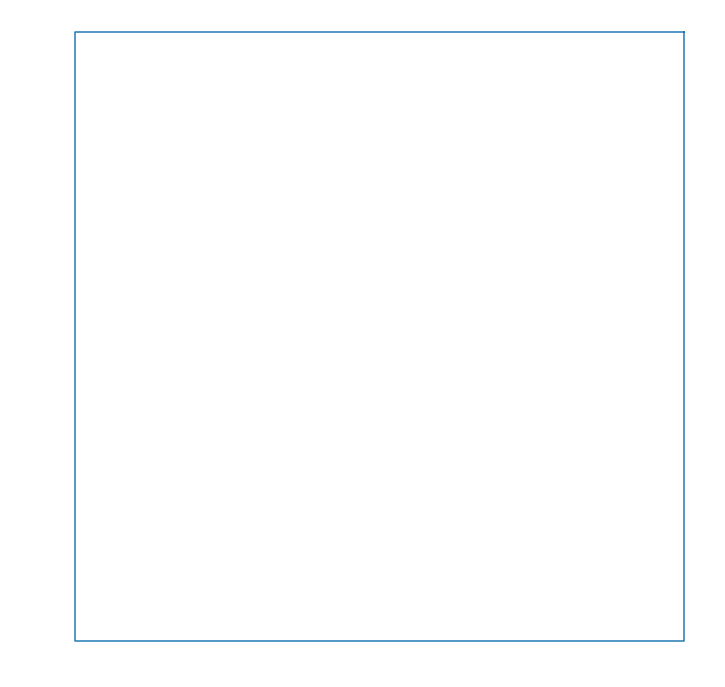

In [49]:
# body to be used in function
# extracts full topological description for a particular state of the system (frame)
# and draw diagram showing cells and also the graph of neighbouring zones
# including perpendiculars to adjacent boundary links
# ----------------------------------------------------------   

def create_prenode_dictionaries(cells):
    pnID = 0
    pn_pj = {}                                               # pnID --> (p,j)
    pn_Pxy = {}                                               # pnID -->  Pxy
    
    for p in cells:
        poly = cells[p]
        for j in  range(len(poly)):
            P = poly[j]
            P.x = round(P.x, 7)
            P.y = round(P.y, 7)
            pn_pj[pnID] = (p, j)
            pn_Pxy[pnID] = (P.x, P.y)
            pnID += 1
    
    return pn_pj, pn_Pxy

pn_pj, pn_Pxy = create_prenode_dictionaries(cell_dict)
area_dict = dict( (p, area(cell_dict[p])) for p in cell_dict)

pj_pn  = invert_dict(pn_pj)                             #  (p,j) --> pnID

Pxy_pn  = invert_dict(pn_Pxy)                           #   Pxy  --> pnID

n_Pxy = {}                                                  #   nID  --> Pxy
pn_n = {}                                                   #   pnID --> nID
nID = 0
for Pxy in Pxy_pn:
    n_Pxy[nID] = Pxy
    for pnID in Pxy_pn[Pxy]:
        pn_n[pnID] = nID
    nID += 1

Nnodes = len(n_Pxy)
Narcs  = len(pn_pj)                                          # number of prenodes = arcs
Nzones = len(seeds)

zone_id = invert_dict(seeds)                             # convert p to conventional 
                                                             # zone number

Pxy_n = invert_dict(n_Pxy)  #   Pxy --> nID
   
n_pn = invert_dict(pn_n)                                # nID  --> [pnID]

next_pn = {}                                                # pnID --> pnID
#prev_pn = {}                                                # pnID --> pnID

for p in cell_dict:
    for j in range(len(cell_dict[p])):
        pn1 = pj_pn[(p, j)]
        nextj = (j + 1) % len(cell_dict[p])
        pn2 = pj_pn[(p, nextj)]
        next_pn[pn1] = pn2
#        prev_pn[pn2] = pn1
# creating interior links (linked_pn)
linked_pn = {}                                               
# a second pn_pn dict, which registers the fact that interior arcs occur in pairs
for zo in range(Nzones):
    p = seeds[zo]
    poly = cell_dict[p]
    for j in range(len(poly)):
        arc1 = pj_pn[(p, j)]
        for arc2 in n_pn[pn_n[next_pn[arc1]]]:
            if pn_n[next_pn[arc2]] == pn_n[arc1]:
                linked_pn[arc1] = arc2
                
Ninterior_arcs = len(linked_pn)
Euler_number = Nzones + Nnodes - (Narcs - Ninterior_arcs // 2)
print('Euler number = ', Euler_number)
# dict containing lists of neighbouring zones                

# create adjacent_zones dict
def create_adjacent_zones_dict():
    z_z = {}
    for z in range(Nzones):
        z_z[z] = []
    
    for a in linked_pn:
        b = linked_pn[a]
        za = zone_id[pn_pj[a][0]]
        zb = zone_id[pn_pj[b][0]]
        z_z[za].append(zb)    
    return z_z

z_z = create_adjacent_zones_dict()
adjacent_zones_dict = z_z

figurehead(12)
axis("off")
polyplot(SQ)
for p in cell_dict: 
    peedraw(fill, cell_dict[p], 'k', poly = True)
    peedraw(plot, cell_dict[p],  poly = True, alpha = 0.7)
#peedraw(scatter, list(zone_id), 30)
#for p in seeds.values():
#    text(p.x, p.y, str(zone_id[p]))  
for z1 in range(Nzones):
    for z2 in z_z[z1]:
        peedraw(plot,[seeds[z1], seeds[z2]], 'w', linewidth = 0.8, alpha = 0.1)

for p in seeds.values():
    poly = cell_dict[p]
    B = barycenter(poly)
    Bcircle = circle(B.x, B.y, 0.25 * area_dict[p], 36)
    peedraw(plot, Bcircle, linewidth = 0.8, poly = True, alpha = 0.95)
    
for n in n_Pxy:
    if len(n_pn[n]) == 3:
        P = n_Pxy[n]
        ncirc = circle(P[0], P[1], 0.02, 12)
        peedraw(fill, ncirc, 'k')
        
bn = 0
for z in range(Nzones):
    poly = cell_dict[seeds[z]]
    pn =[]
    Origin = Point(0,0)
    C = Origin
    for j in range(len(poly)):
        prenodes = Pxy_pn[(poly[j].x, poly[j].y)]
        defect = 3 - len(prenodes)
        if not defect == 0: #boundary
            bn += 1
            if defect == 1: pn.append(poly[j])
            elif defect == 2: C = poly[j] #corner
   
    if len(pn) == 2:   
        B1 = barycenter(poly)
        P = pn[0]
        Q = pn[1]
        if C == Origin:    
            B2 = B1.half_reflect(P, Q)
            peedraw(plot, [B1, B2], 'w--', linewidth = 0.8, alpha = 0.3)        
        else:
            B2 = B1.half_reflect(P, C)
            B3 = B1.half_reflect(C, Q)
            peedraw(plot, [B1, B2], 'w--', linewidth = 0.8, alpha = 0.3)        
            peedraw(plot, [B1, B3], 'w--', linewidth = 0.8, alpha = 0.3)        

show()